In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/c107-txt/C107.csv
/kaggle/input/c207-txt/c207.txt
/kaggle/input/solomon-vrptw-benchmark/solomon_dataset/RC1/RC105.csv
/kaggle/input/solomon-vrptw-benchmark/solomon_dataset/RC1/RC108.csv
/kaggle/input/solomon-vrptw-benchmark/solomon_dataset/RC1/RC103.csv
/kaggle/input/solomon-vrptw-benchmark/solomon_dataset/RC1/RC107.csv
/kaggle/input/solomon-vrptw-benchmark/solomon_dataset/RC1/RC106.csv
/kaggle/input/solomon-vrptw-benchmark/solomon_dataset/RC1/RC102.csv
/kaggle/input/solomon-vrptw-benchmark/solomon_dataset/RC1/RC104.csv
/kaggle/input/solomon-vrptw-benchmark/solomon_dataset/RC1/RC101.csv
/kaggle/input/solomon-vrptw-benchmark/solomon_dataset/C2/C208.csv
/kaggle/input/solomon-vrptw-benchmark/solomon_dataset/C2/C205.csv
/kaggle/input/solomon-vrptw-benchmark/solomon_dataset/C2/C201.csv
/kaggle/input/solomon-vrptw-benchmark/solomon_dataset/C2/C207.csv
/kaggle/input/solomon-vrptw-benchmark/solomon_dataset/C2/C204.csv
/kaggle/input/solomon-vrptw-benchmark/solomon_dataset/C2/C206.

In [2]:
#show the dataset c207 from solomon
import pandas as pd

file_path = '//kaggle/input/c207-txt/c207.txt' 

with open(file_path, 'r') as file:
    lines = file.readlines()

start_index = 0
for i, line in enumerate(lines):
    if "CUSTOMER" in line:
        start_index = i + 2  
        break


data = []
for line in lines[start_index:]:
    parts = line.strip().split()
    if len(parts) < 7:
        continue
    customer = int(parts[0])
    x = float(parts[1])
    y = float(parts[2])
    demand = int(parts[3])
    ready = int(parts[4])
    due = int(parts[5])
    service = int(parts[6])
    data.append([customer, x, y, demand, ready, due, service])


columns = ["Customer", "X","Y", "Demand", "ReadyTime", "DueDate", "ServiceTime"]
df = pd.DataFrame(data, columns=columns)

df.head(20)


,Customer,X,Y,Demand,ReadyTime,DueDate,ServiceTime
0,0,40.0,50.0,0,0,3390,0
1,1,52.0,75.0,10,302,479,90
2,2,45.0,70.0,30,157,428,90
3,3,62.0,69.0,10,1138,1355,90
4,4,60.0,66.0,10,1247,1434,90
5,5,42.0,65.0,10,15,208,90
6,6,16.0,42.0,20,209,944,90
7,7,58.0,70.0,20,1059,1246,90
8,8,34.0,60.0,20,2035,3288,90
9,9,28.0,70.0,10,2090,3271,90


Best path using Nearest Neighbor + BWKA:
[93, 5, 75, 2, 1, 99, 100, 97, 95, 94, 92, 98, 7, 3, 4, 89, 91, 88, 86, 84, 83, 82, 77, 78, 81, 76, 71, 70, 73, 79, 80, 85, 87, 96, 74, 62, 66, 69, 67, 63, 61, 64, 72, 65, 68, 41, 42, 43, 47, 45, 50, 51, 52, 6, 32, 33, 34, 36, 39, 38, 37, 35, 31, 29, 27, 24, 22, 20, 21, 8, 10, 11, 9, 25, 23, 26, 28, 30, 13, 17, 18, 19, 15, 16, 14, 12, 90, 48, 46, 44, 40, 57, 55, 54, 59, 58, 56, 53, 60, 49]
Least cost (total distance): 703.97


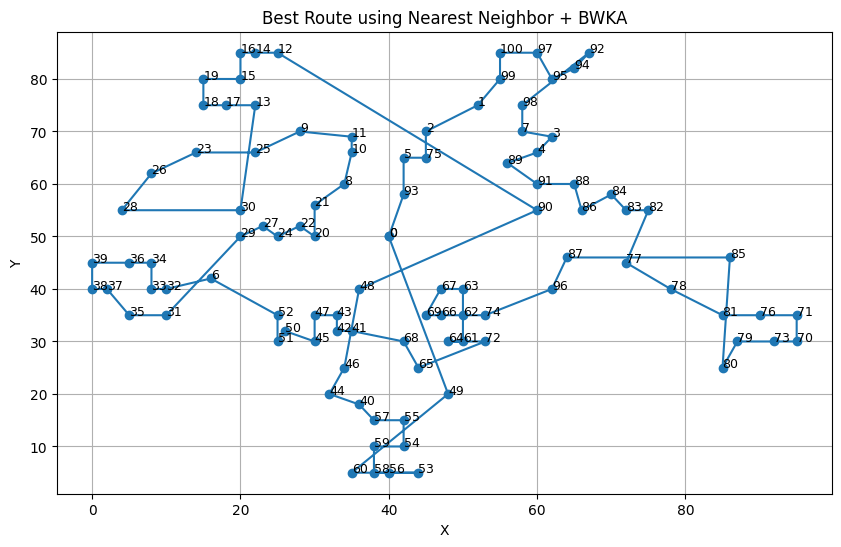

In [3]:
#Nearest Neighbor + BWKA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


file_path = '/kaggle/input/c207-txt/c207.txt'  
with open(file_path, 'r') as file:
    lines = file.readlines()


start_index = 0
for i, line in enumerate(lines):
    if "CUSTOMER" in line:
        start_index = i + 2
        break

data = []
for line in lines[start_index:]:
    parts = line.strip().split()
    if len(parts) < 7:
        continue
    data.append([int(parts[0]), float(parts[1]), float(parts[2]),
                 int(parts[3]), int(parts[4]), int(parts[5]), int(parts[6])])

columns = ["Customer", "X", "Y", "Demand", "ReadyTime", "DueDate", "ServiceTime"]
df = pd.DataFrame(data, columns=columns)


locations = df[["X", "Y"]].values
demands = df["Demand"].values
time_windows = df[["ReadyTime", "DueDate"]].values
service_times = df["ServiceTime"].values
vehicle_capacity = 700

def compute_distance_matrix(locations):
    n = len(locations)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_matrix[i][j] = np.linalg.norm(locations[i] - locations[j])
    return dist_matrix

distance_matrix = compute_distance_matrix(locations)


def nearest_neighbor_route(dist_matrix, start=0):
    n = len(dist_matrix)
    unvisited = set(range(1, n))
    route = []
    current = start
    while unvisited:
        next_node = min(unvisited, key=lambda x: dist_matrix[current][x])
        route.append(next_node)
        unvisited.remove(next_node)
        current = next_node
    return route

def initialize_population_nn(pop_size, dist_matrix):
    base_route = nearest_neighbor_route(dist_matrix)
    population = [base_route.copy() for _ in range(pop_size)]
    for i in range(1, pop_size):
        route = population[i]
        i1, i2 = np.random.choice(len(route), 2, replace=False)
        route[i1], route[i2] = route[i2], route[i1]
    return population


def evaluate_solution(route, dist_matrix):
    total_distance = 0
    prev = 0 
    for node in route:
        total_distance += dist_matrix[prev][node]
        prev = node
    total_distance += dist_matrix[prev][0] 
    return total_distance


def bwka(dist_matrix, population_size=10, iterations=100):
    population = initialize_population_nn(population_size, dist_matrix)
    best_solution = None
    best_fitness = float('inf')

    for _ in range(iterations):
        fitnesses = [evaluate_solution(route, dist_matrix) for route in population]
        min_idx = np.argmin(fitnesses)

        if fitnesses[min_idx] < best_fitness:
            best_fitness = fitnesses[min_idx]
            best_solution = population[min_idx]

       
        new_population = []
        for route in population:
            new_route = route.copy()
            i, j = np.random.choice(len(new_route), 2, replace=False)
            new_route[i], new_route[j] = new_route[j], new_route[i]
            new_population.append(new_route)

        population = new_population

    return best_solution, best_fitness


best_route, best_cost = bwka(distance_matrix, population_size=20, iterations=200)

print("Best path using Nearest Neighbor + BWKA:")
print(best_route)
print("Least cost (total distance):", round(best_cost, 2))


def plot_route(route, locations):
    ordered = [0] + list(route) + [0]
    xs = [locations[i][0] for i in ordered]
    ys = [locations[i][1] for i in ordered]

    plt.figure(figsize=(10, 6))
    plt.plot(xs, ys, marker='o')
    for idx in ordered:
        plt.text(locations[idx][0], locations[idx][1], str(idx), fontsize=9)
    plt.title("Best Route using Nearest Neighbor + BWKA")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

plot_route(best_route, locations)


best route BWKA: [ 21  14   3  25  29  51  38  89  94  59  77   4  10  23  39  52  82  11
  98  44  53  40  55  66  74  18  24  73  58  19  32  17  96  93  80  99
   7  95   5   1  81  65  47  33  84  92  45  57  41  62  42  46  83  36
  56  54  78  88   2  75  34  15  90  79  72  20  49  71  16  37  28  13
  27  48  69  91  22  63  60  26  97   8  76  68  70  87  50  61  35  31
  30  67  85  43   6  64  12   9  86 100]
Lowest cost (dist) BWKA: 3553.64
Best route using Nearest Neighbor: [0, 93, 5, 75, 2, 1, 99, 100, 97, 95, 94, 92, 98, 7, 3, 4, 89, 91, 88, 86, 84, 83, 82, 77, 78, 81, 76, 71, 70, 73, 79, 80, 85, 87, 96, 74, 62, 66, 69, 67, 63, 61, 64, 72, 65, 68, 41, 42, 43, 47, 45, 50, 51, 52, 6, 32, 33, 34, 36, 39, 38, 37, 35, 31, 29, 27, 24, 22, 20, 21, 8, 10, 11, 9, 25, 23, 26, 28, 30, 13, 17, 18, 19, 15, 16, 14, 12, 90, 48, 46, 44, 40, 57, 55, 54, 59, 58, 56, 53, 60, 49]
Lowest cost (dist) Nearest Neighbor: 703.97


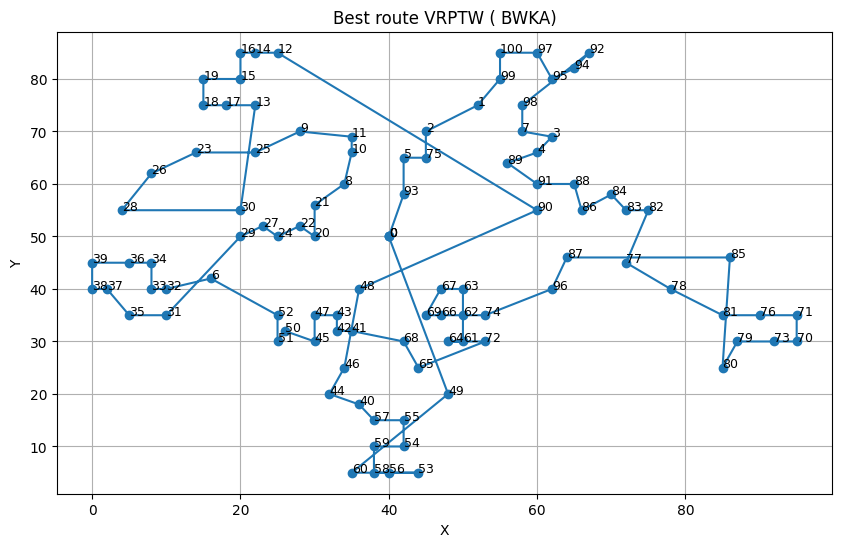

In [4]:
#Nearest Neighbor + BWKA (seprete)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


file_path = '/kaggle/input/c207-txt/c207.txt'  

with open(file_path, 'r') as file:
    lines = file.readlines()


start_index = 0
for i, line in enumerate(lines):
    if "CUSTOMER" in line:
        start_index = i + 2
        break


data = []
for line in lines[start_index:]:
    parts = line.strip().split()
    if len(parts) < 7:
        continue
    data.append([int(parts[0]), float(parts[1]), float(parts[2]),
                 int(parts[3]), int(parts[4]), int(parts[5]), int(parts[6])])

columns = ["Customer", "X", "Y", "Demand", "ReadyTime", "DueDate", "ServiceTime"]
df = pd.DataFrame(data, columns=columns)

locations = df[["X", "Y"]].values
demands = df["Demand"].values
time_windows = df[["ReadyTime", "DueDate"]].values
service_times = df["ServiceTime"].values
vehicle_capacity = 700
num_customers = len(df)


def compute_distance_matrix(locations):
    n = len(locations)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_matrix[i][j] = np.linalg.norm(locations[i] - locations[j])
    return dist_matrix

distance_matrix = compute_distance_matrix(locations)

#Nearest Neighbor
def nearest_neighbor(start, dist_matrix):
    n = len(dist_matrix)
    visited = [False] * n
    route = [start] 
    visited[start] = True
    current = start
    
    while len(route) < n:
       
        nearest = None
        nearest_dist = float('inf')
        for i in range(n):
            if not visited[i] and dist_matrix[current][i] < nearest_dist:
                nearest = i
                nearest_dist = dist_matrix[current][i]
        route.append(nearest)
        visited[nearest] = True
        current = nearest
    
    return route


def initialize_population(pop_size, num_nodes):
    return [np.random.permutation(np.arange(1, num_nodes)) for _ in range(pop_size)]

def evaluate_solution(route, dist_matrix):
    total_distance = 0
    prev = 0  # depot
    for node in route:
        total_distance += dist_matrix[prev][node]
        prev = node
    total_distance += dist_matrix[prev][0] 
    return total_distance

def bwka(dist_matrix, population_size=10, iterations=100):
    population = initialize_population(population_size, len(dist_matrix))
    best_solution = None
    best_fitness = float('inf')

    for _ in range(iterations):
        fitnesses = [evaluate_solution(route, dist_matrix) for route in population]
        min_idx = np.argmin(fitnesses)

        if fitnesses[min_idx] < best_fitness:
            best_fitness = fitnesses[min_idx]
            best_solution = population[min_idx]

        
        new_population = []
        for route in population:
            new_route = route.copy()
            i, j = np.random.choice(len(new_route), 2, replace=False)
            new_route[i], new_route[j] = new_route[j], new_route[i]
            new_population.append(new_route)

        population = new_population

    return best_solution, best_fitness


best_route, best_cost = bwka(distance_matrix)


initial_route = nearest_neighbor(0, distance_matrix)
initial_cost = evaluate_solution(initial_route, distance_matrix)


print("best route BWKA:", best_route)
print("Lowest cost (dist) BWKA:", round(best_cost, 2))
print("Best route using Nearest Neighbor:", initial_route)
print("Lowest cost (dist) Nearest Neighbor:", round(initial_cost, 2))

import matplotlib.pyplot as plt

def plot_all_routes(routes, locations, title="VRPTW Routes"):
    plt.figure(figsize=(12, 8))
    cmap = plt.colormaps['tab20']  # خريطة الألوان
    N = len(routes)

    for i, route in enumerate(routes):
        ordered = [0] + route + [0]  # بداية ونهاية من الـ depot
        xs = [locations[idx][0] for idx in ordered]
        ys = [locations[idx][1] for idx in ordered]

        color = cmap(i / N)  # لون مختلف بناءً على النسبة
        plt.plot(xs, ys, marker='o', linestyle='-', color=color, label=f"Vehicle {i+1}")
        for idx in ordered:
            plt.text(locations[idx][0], locations[idx][1], str(idx), fontsize=8)

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()



def plot_route(route, locations):
    ordered = [0] + list(route) + [0]
    xs = [locations[i][0] for i in ordered]
    ys = [locations[i][1] for i in ordered]
    
    plt.figure(figsize=(10, 6))
    plt.plot(xs, ys, marker='o')
    for i, idx in enumerate(ordered):
        plt.text(locations[idx][0], locations[idx][1], str(idx), fontsize=9)
    plt.title("Best route VRPTW ( BWKA)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()


plot_route(initial_route, locations)


 Simulated Annealing 
Route: [16, 98, 77, 96, 22, 32, 30, 2, 26, 6, 34, 36, 52, 97, 95, 94, 59, 46, 79, 23, 14, 15, 60, 54, 93, 89, 78, 64, 53, 42, 82, 88, 74, 76, 86, 90, 41, 56, 87, 85, 71, 9, 28, 38, 21, 11, 83, 62, 55, 27, 24, 19, 12, 25, 67, 91, 31, 35, 29, 49, 81, 80, 70, 73, 4, 58, 68, 13, 45, 33, 20, 10, 7, 75, 18, 8, 99, 3, 61, 72, 50, 47, 48, 63, 84, 65, 44, 43, 37, 1, 5, 92, 100, 57, 66, 51, 39, 17, 69, 40]
Total Distance: 2889.28


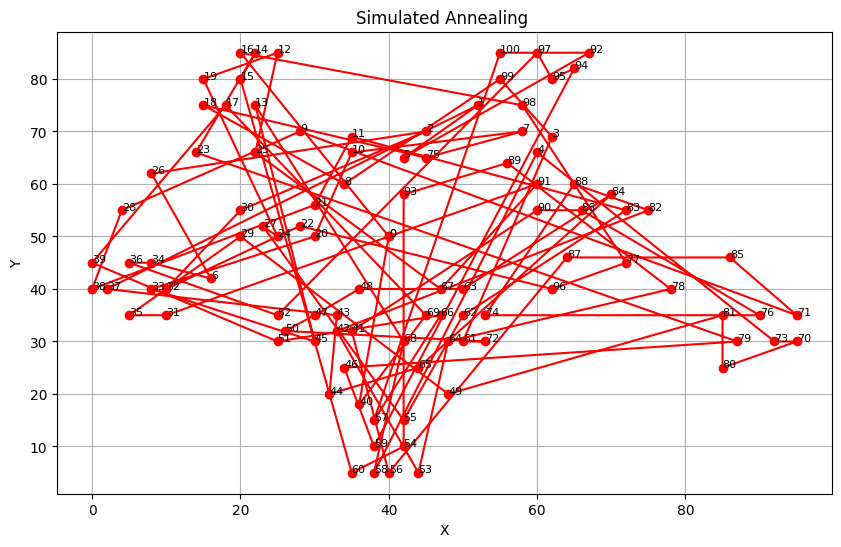

In [5]:
#Simulated Annealing 
import numpy as np
import pandas as pd

file_path = '/kaggle/input/c207-txt/c207.txt'  

with open(file_path, 'r') as file:
    lines = file.readlines()
  
df.columns = ["Customer", "X", "Y", "Demand", "ReadyTime", "DueDate", "ServiceTime"]
locations = df[["X", "Y"]].values

def compute_distance_matrix(locs):
    n = len(locs)
    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist[i][j] = np.linalg.norm(locs[i] - locs[j])
    return dist

distance_matrix = compute_distance_matrix(locations)

def evaluate_route(route, distance_matrix):
    cost = 0
    prev = 0
    for node in route:
        cost += distance_matrix[prev][node]
        prev = node
    cost += distance_matrix[prev][0]
    return cost

def generate_random_solution(num_customers):
    return list(np.random.permutation(range(1, num_customers)))  

def perturb(route):
    new_route = route.copy()
    i, j = np.random.choice(len(route), 2, replace=False)
    new_route[i], new_route[j] = new_route[j], new_route[i]
    return new_route

def bad_simulated_annealing(distance_matrix, num_customers, initial_temp=1000, cooling_rate=0.90, iterations=200):
    current_solution = generate_random_solution(num_customers)
    best_solution = current_solution.copy()
    current_cost = evaluate_route(current_solution, distance_matrix)
    best_cost = current_cost
    temp = initial_temp

    for _ in range(iterations):
        new_solution = perturb(current_solution)
        new_cost = evaluate_route(new_solution, distance_matrix)
        if new_cost < current_cost or np.random.rand() < np.exp((current_cost - new_cost) / temp):
            current_solution = new_solution
            current_cost = new_cost
            if new_cost < best_cost:
                best_solution = new_solution
                best_cost = new_cost
        temp *= cooling_rate 
    return best_solution, best_cost

num_customers = len(df)
bad_route, bad_cost = bad_simulated_annealing(distance_matrix, num_customers)

print(" Simulated Annealing ")
print("Route:", bad_route)
print("Total Distance:", round(bad_cost, 2))

import matplotlib.pyplot as plt

def plot_route(route, locations, title="Simulated Annealing "):
    ordered = [0] + route + [0] 
    xs = [locations[i][0] for i in ordered]
    ys = [locations[i][1] for i in ordered]

    plt.figure(figsize=(10, 6))
    plt.plot(xs, ys, marker='o', linestyle='-', color='red')
    for idx in ordered:
        plt.text(locations[idx][0], locations[idx][1], str(idx), fontsize=8)
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

plot_route(bad_route, locations)
